In [1]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import scipy

from utils.depth_camera import DepthCamera

In [2]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [157]:
data_dir = "data/exp_7"
trial = "trial_1"
subject = "subject-1"
sequence = 3

In [142]:
motion_dir = os.path.join(data_dir, trial, subject, f"{sequence:02d}", "motion")

In [143]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accelerometer"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyroscope"))

In [144]:
accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

In [145]:
imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

In [146]:
alpha = 0.8
gravity = [0, 0, 0]

for i in range(imu_df.shape[0]):
    for j in range(3):
        gravity[j] = alpha * gravity[j] + (1 - alpha) * imu_df.iloc[i, 1 + j]
        imu_df.iloc[i, 1 + j] = imu_df.iloc[i, 1 + j] - gravity[j]

In [147]:
# remove first second's data (as it stabilizes the gravity)
imu_df = imu_df.iloc[400:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

In [148]:
# Fill 0 for displacement and angles
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [153]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in range(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        # velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        imu_df.iloc[i, 11 + j] = np.degrees(angle[j])

        velocity[j] = velocity[j] + imu[j + 1] * dt

In [154]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [155]:
for i in range(1, len(imu_df)):
    c = imu_df.iloc[i].values           # current readings
    p = imu_df.iloc[i - 1].values       # previous readings

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([c[8], c[9], c[10], 1]))

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

In [156]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

open3d.visualization.draw_geometries([pcd])

In [ ]:
camera = DepthCamera("lidar", "data/exp_7/metadata/device-0-aligned.json")

In [ ]:
sequence_dir = os.path.join(data_dir, trial, subject, f"{sequence:02d}", "frames")
sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")

In [ ]:
start_t = sequence_ts[0]
end_t = sequence_ts[-1]

In [ ]:
# accel_t = accel_df[(accel_df.timestamp >= start_t) & (accel_df.timestamp <= end_t)]
accel_t = accel_df.iloc[400:].copy()
# remove redundant data
accel_t = accel_t.drop_duplicates("timestamp")
# calculating time difference
accel_t.loc[:, "dt"] = np.concatenate([[0], (accel_t.timestamp.values[1:] - accel_t.timestamp.values[:-1]) / 1000])
# accel_t.loc[:, "dt"] = (accel_t.timestamp.values - accel_t.timestamp.values[0]) / 1000
# remove first row
accel_t = accel_t.iloc[1:]

accel_t.reset_index(drop=True, inplace=True)

In [ ]:
gyro_t = gyro_df.iloc[400:].copy()
# remove redundant data
gyro_t = gyro_t.drop_duplicates("timestamp")
# calculating time difference
# gyro_t.loc[:, "dt"] = np.concatenate([[0], (gyro_t.timestamp.values[1:] - gyro_t.timestamp.values[:-1]) / 1000])
gyro_t.loc[:, "dt"] = (gyro_t.timestamp.values - gyro_t.timestamp.values[0]) / 1000
# remove first row
gyro_t = gyro_t.iloc[1:]

In [ ]:
accel_t.loc[:, "Ix"] = np.zeros(len(accel_t))
accel_t.loc[:, "Iy"] = np.zeros(len(accel_t))
accel_t.loc[:, "Iz"] = np.zeros(len(accel_t))

accel_t.loc[:, "I2x"] = np.zeros(len(accel_t))
accel_t.loc[:, "I2y"] = np.zeros(len(accel_t))
accel_t.loc[:, "I2z"] = np.zeros(len(accel_t))

In [ ]:
displacement = [0, 0, 0]
velocity = [0, 0, 0]

for i in range(len(accel_t)):
    imu = accel_t.iloc[i].values
    for j, axis in enumerate(["x", "y", "z"]):
        velocity[j] = velocity[j] + imu[j + 1] * imu[4] # 4 = dt
        # Update the displacement
        displacement[j] = displacement[j] + (velocity[j] * imu[4]) + (0.5 * imu[j + 1] * imu[4] * imu[4])

        accel_t.iloc[i, 5 + j] = velocity[j]
        accel_t.iloc[i, 8 + j] = displacement[j]

In [ ]:
# accel_t.loc[:, "Ix"] = scipy.integrate.cumtrapz(accel_t.x.values, accel_t.dt.values, initial=0)
# accel_t.loc[:, "Iy"] = scipy.integrate.cumtrapz(accel_t.y.values, accel_t.dt.values, initial=0)
# accel_t.loc[:, "Iz"] = scipy.integrate.cumtrapz(accel_t.z.values, accel_t.dt.values, initial=0)
#
# accel_t.loc[:, "I2x"] = scipy.integrate.cumtrapz(accel_t.Ix.values, accel_t.dt.values, initial=0)
# accel_t.loc[:, "I2y"] = scipy.integrate.cumtrapz(accel_t.Iy.values, accel_t.dt.values, initial=0)
# accel_t.loc[:, "I2z"] = scipy.integrate.cumtrapz(accel_t.Iz.values, accel_t.dt.values, initial=0)

In [ ]:
# accel_t.set_index("timestamp").loc[:, ["x", "y", "z"]].plot()
accel_t.set_index("timestamp").loc[:, ["I2x", "I2y", "I2z"]].plot()
# axis = "z"
# accel_t.iloc[1000:].set_index("timestamp").loc[:, [f"I{axis}", f"I2{axis}"]].plot()

In [ ]:
# t = accel_t.I2x.values, accel_t.I2y.sum(), accel_t.I2z.sum()
t = accel_t.values[-1, -3:]

In [ ]:
# gyro_t = gyro_df[(accel_df.timestamp >= start_t) & (accel_df.timestamp <= end_t)]
gyro_t = gyro_df.copy()
# remove redundant data
gyro_t = gyro_t.drop_duplicates("timestamp")
# calculating time difference
# gyro_t.loc[:, "dt"] = np.concatenate([[0], (gyro_t.timestamp.values[1:] - gyro_t.timestamp.values[:-1]) / 1000])
gyro_t.loc[:, "dt"] = (gyro_t.timestamp.values - gyro_t.timestamp.values[0]) / 1000
# remove first row
gyro_t = gyro_t.iloc[1:]

In [ ]:
gyro_t.loc[:, "Ix"] = scipy.integrate.cumtrapz(gyro_t.x.values, gyro_t.dt.values, initial=0)
gyro_t.loc[:, "Iy"] = scipy.integrate.cumtrapz(gyro_t.y.values, gyro_t.dt.values, initial=0)
gyro_t.loc[:, "Iz"] = scipy.integrate.cumtrapz(gyro_t.z.values, gyro_t.dt.values, initial=0)

In [ ]:
gyro_t.set_index("timestamp").loc[:, ["Ix", "Iy", "Iz"]].plot()

In [ ]:
# R = gyro_t.Ix.sum(), gyro_t.Iy.sum(), gyro_t.Iz.sum()
R = gyro_t.values[-1, -3:]

In [ ]:
T = helpers.rotate_transformation_matrix(np.identity(4), R[0], R[1], R[2])
T[:3, 3] = t

In [ ]:
print(f"Translation: {t}", end="\t")
print(f"Rotation: {R}")

In [ ]:
source = camera.depth_to_point_cloud(os.path.join(sequence_dir, f"frame-{start_t}.depth.png"))
target = camera.depth_to_point_cloud(os.path.join(sequence_dir, f"frame-{end_t}.depth.png"))

In [ ]:
registration.view(source, target, T)

In [ ]:
accel_df = accel_df.drop_duplicates("timestamp")

In [ ]:
samples = accel_df.shape[0]
duration = accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]

In [ ]:
samples / duration * 1000

Experiment to check integration with simulated data

In [ ]:
imu = [[2] for _ in range(2000)] + [[0] for _ in range(3000)] + [[-2] for _ in range(2000)]
timestamps = [[i] for i in range(7000)]

data = np.concatenate([timestamps, imu], axis=1)

accel_df = pd.DataFrame(data, columns=["timestamp", "x"])

In [ ]:
accel_df.loc[:, "dt"] = (accel_df.timestamp.values - accel_df.timestamp.values[0]) / 1000
# remove first row
accel_df = accel_df.iloc[1:]

In [ ]:
accel_df.loc[:, "Ix"] = scipy.integrate.cumtrapz(accel_df.x.values, accel_df.dt.values, initial=0)

In [ ]:
accel_df.loc[:, "I2x"] = scipy.integrate.cumtrapz(accel_df.Ix.values, accel_df.dt.values, initial=0)

In [ ]:
accel_df.set_index("timestamp").loc[:, ["x", "Ix", "I2x"]].plot()

In [ ]:
d = 0.5 * 2 * 4 + 4 * 3 + 0.5 * 4 * 2
print(f"Total distance: {d}")

Linear acceleration from Android API

In [131]:
accel_df = pd.read_csv("data/android/1672368036122/acceleration.csv", names=["timestamp", "x", "y", "z"])
gyro_df = pd.read_csv("data/android/1672368036122/gyroscope.csv", names=["timestamp", "x", "y", "z"])

In [132]:
accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

<AxesSubplot:xlabel='timestamp'>

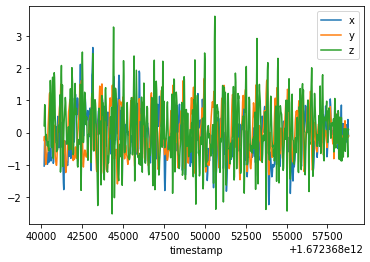

In [133]:
accel_df.loc[200:, ["timestamp", "x", "y", "z"]].set_index("timestamp").plot()

In [134]:
accel_df = accel_df.iloc[175:]

accel_df.loc[:, "gyro_t"] = accel_df.apply(lambda x: nearest(gyro_df.timestamp.values, x.timestamp), axis=1)

imu_df = pd.merge(
    accel_df.loc[:, ["gyro_t", "x", "y", "z"]],
    gyro_df.loc[:, ["timestamp", "x", "y", "z"]],
    left_on="gyro_t",
    right_on="timestamp",
    suffixes=("a", "g")
)

imu_df.drop("gyro_t", axis=1, inplace=True)
imu_df = imu_df.loc[:, ["timestamp", "xa", "ya", "za", "xg", "yg", "zg"]]

In [135]:
# remove first second's data (as it stabilizes the gravity)
# imu_df = imu_df.iloc[400:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

In [136]:
# Fill 0 for displacement and angles
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [137]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in range(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        # velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        # imu_df.iloc[i, 11 + j] = imu[j + 4] * dt
        imu_df.iloc[i, 11 + j] = np.degrees(angle[j])

        velocity[j] = velocity[j] + imu[j + 1] * dt

In [138]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [139]:
for i in range(1, len(imu_df)):
    c = imu_df.iloc[i].values           # current readings
    p = imu_df.iloc[i - 1].values       # previous readings

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([c[8], c[9], c[10], 1]))

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

In [140]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

open3d.visualization.draw_geometries([pcd])

<AxesSubplot:xlabel='dt'>

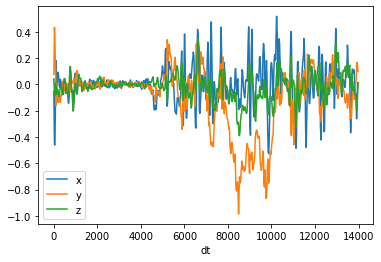

In [129]:
gyro_df.loc[:, "dt"] = gyro_df.timestamp.values - gyro_df.timestamp.values[0]

gyro_df.set_index("dt").loc[:, ["x", "y", "z"]].plot()

In [130]:
np.rad2deg(3.142)

180.02333923010465